# PI - NLP

Autor: <font color=red>Roger Ribeiro Fava Pina</font>

Enunciado do problema
Um problema que as empresas varejistas têm é o de conseguir entender pontos em que podem melhorar seus serviços. Para isso, precisam de dados, que geralmente são conseguidos em pesquisas de opinião ou no registro do comportamento de compras - por exemplo, se todos os clientes deixam de comprar um determinado produto, isso pode significar que mantê-lo nas prateleiras é um ônus para um supermercado. No caso do e-commerce, o acesso a dados tem a característica de permitir que usuários que fizeram compras registrem suas impressões por meio de estrelas (1 a 5 estrelas) e comentários.

Os comentários são tipicamente dados não-estruturados, isto é, o usuário é livre para escrever o que quiser. Por isso, são uma fonte rica de informações e, ao mesmo tempo, uma fonte difícil de lidar, já que é preciso usar técnicas de NLP para entender o que está sendo dito.

Neste exercício, utilizaremos a base de dados disponibilizada pela Olist em:

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

para descobrir: <font color=red>Quais são os fatores que mais aborrecem os clientes em suas compras online?</font>

In [195]:
import joblib
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Activation
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer

url = "https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt"
stopwords_list = urllib.request.urlopen(url).read().decode()
stopwords_ptbr = set(stopwords_list.split())
stopwords_ptbr.remove('não')

In [196]:
csv_path = "data/olist_order_reviews_dataset.csv"
df_ = pd.read_csv(csv_path)

In [197]:
df_

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


# Pré-processamento

## Limpando do Dataset

- Eliminar célular em branco

In [198]:
df_ = df_[['review_score', 'review_comment_message']]

Mantive apenas as colunas interessantes para análise. Sendo elas o score, título do comentário e comentário em si. 

### Removendo todos "nan"

In [199]:
df_drop_na = df_.dropna()

In [200]:
df_drop_na.describe()

,review_score
count,40977.000000
mean,3.669864
std,1.615418
min,1.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


In [201]:
(df_drop_na.describe().iloc[0].values[0] / df_.describe().iloc[0].values[0]) * 100

41.29746835443038

Ao dropar todos "Nan"s do dataset sobram menos de 10000 linhas, menos de 10% dos dados originais. Entretanto, dentre as 3 colunas de dados que serão utilizadas, a que será capaz de fornecer informação suficiente para responder quais são os fatores que mais aborrecem os clientes em suas compras online é a coluna: "review_comment_message". Com isso, irei remover apenas as linhas que possuem Nan nessa coluna.

### Removendo todos "nan" da coluna "review_comment_message"

In [202]:
df_drop_na_msg = df_[df_['review_comment_message'].notna() & df_['review_score'].notna() ]

In [203]:
df_drop_na_msg.describe()

,review_score
count,40977.000000
mean,3.669864
std,1.615418
min,1.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


In [204]:
(df_drop_na_msg.describe().iloc[0].values[0] / df_.describe().iloc[0].values[0]) * 100

41.29746835443038

Com essa limpeza sobram mais de 40% dos dados inicias, uma quantidade maior que a outra remoção de dados testada além de que mantém dados capazes de trazer mais informação.

In [205]:
df = df_drop_na_msg

## Tokenização

In [206]:
df
df_orig = df.copy()

In [207]:
# Encode scores to be Satisfied or Not Satisfied
encoded_class = { 1 : 'Aborrecido',
                  2 : 'Aborrecido', 
                  3 : 'Aborrecido', 
                  4 : 'Satisfeito', 
                  5 : 'Satisfeito'}

df_orig['review_score'] = df_orig['review_score'].map(encoded_class)
df['review_score'] = df['review_score'].map(encoded_class)

C:\Users\roger\AppData\Local\Temp\ipykernel_11384\3615129537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_score'] = df['review_score'].map(encoded_class)


In [208]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
REGEX = r'\b\w+\b'

def clean_comments(comment):
    text = re.findall(REGEX, comment.lower())
    text = [stemmer.stem(word) for word in text if word not in stopwords_ptbr]
    text = ' '.join(text)
    return text

df['review_comment_message'] = df['review_comment_message'].apply(lambda x: clean_comments(x))

C:\Users\roger\AppData\Local\Temp\ipykernel_11384\1341785413.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_comment_message'] = df['review_comment_message'].apply(lambda x: clean_comments(x))


In [209]:
df

,review_score,review_comment_message
3,Satisfeito,recebi bem ant prazo estipulado
4,Satisfeito,parabén loja lannist adorei comprar internet s...
9,Satisfeito,aparelho eficient site marca aparelho impresso...
12,Satisfeito,pouco travando valor ta boa
15,Satisfeito,vendedor confiável produto ok entrega ant prazo
...,...,...
99205,Satisfeito,produto recebi acordo compra realizada
99208,Satisfeito,entreg dentro prazo produto chegou condiçõ per...
99215,Aborrecido,produto não enviado nf não exist venda nf cert...
99221,Satisfeito,excelent mochila entrega super rápida super re...


# Análise de sentimentos

In [210]:
X = df['review_comment_message']
y = df['review_score']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y)

In [212]:
classificador = Pipeline([
    ('meu_vetorizador', CountVectorizer(stop_words=stopwords_ptbr)),
    ('meu_classificador', LogisticRegression(solver='saga', max_iter=10000))
])

In [213]:
classificador.fit(X_train, y_train)
y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print(acc)

0.8929900555182723


C:\Users\roger\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\roger\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


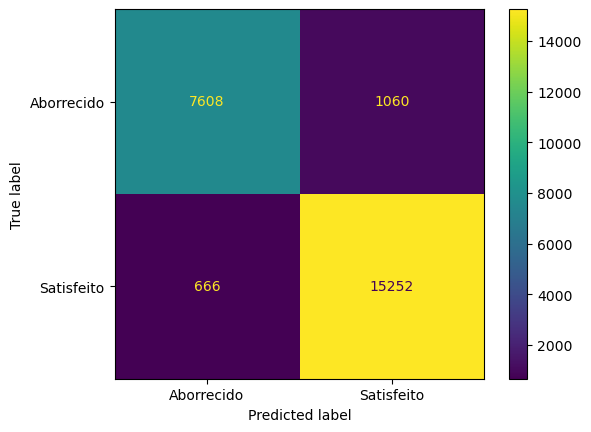

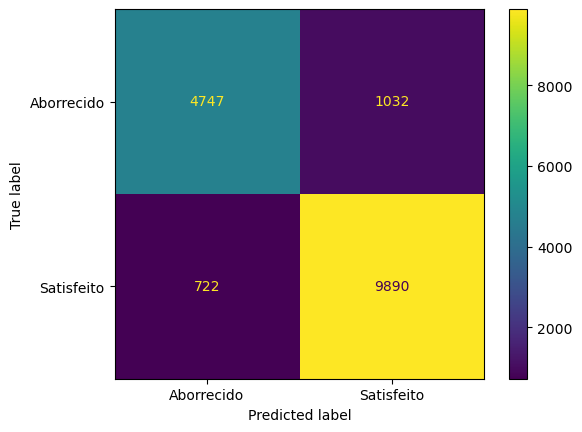

In [214]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classificador, X_train, y_train)
plot_confusion_matrix(classificador, X_test, y_test)

# Identificação dos fatores de aborrecimento

In [215]:
df_aborrecido = df[df.review_score == 'Aborrecido']

# Reset index
df_aborrecido.reset_index(inplace= True, drop= True)

In [216]:
df_aborrecido

,review_score,review_comment_message
0,Aborrecido,gostaria saber sempr recebi compra agora decpcion
1,Aborrecido,péssimo
2,Aborrecido,não gostei comprei gato lebr
3,Aborrecido,sempr compro internet entrega ocorr ant prazo ...
4,Aborrecido,nada chegar pedido
...,...,...
14442,Aborrecido,bom dia 6 unidad comprada recebi 4 unidad agua...
14443,Aborrecido,foto diferent principalment graninha sintética...
14444,Aborrecido,problema entrega correio coloc site entregu di...
14445,Aborrecido,produto não enviado nf não exist venda nf cert...


In [217]:
vocab = dict()
for text in df_aborrecido['review_comment_message']:
    text = text.split()
    for word in text:
        if word not in vocab:
            vocab[word] = 0
        vocab[word] += 1

In [218]:
vocab_list = []
for word, freq in vocab.items():
    for e in range(freq):
        vocab_list.append(word)
np.random.shuffle(vocab_list)

(-0.5, 999.5, 799.5, -0.5)

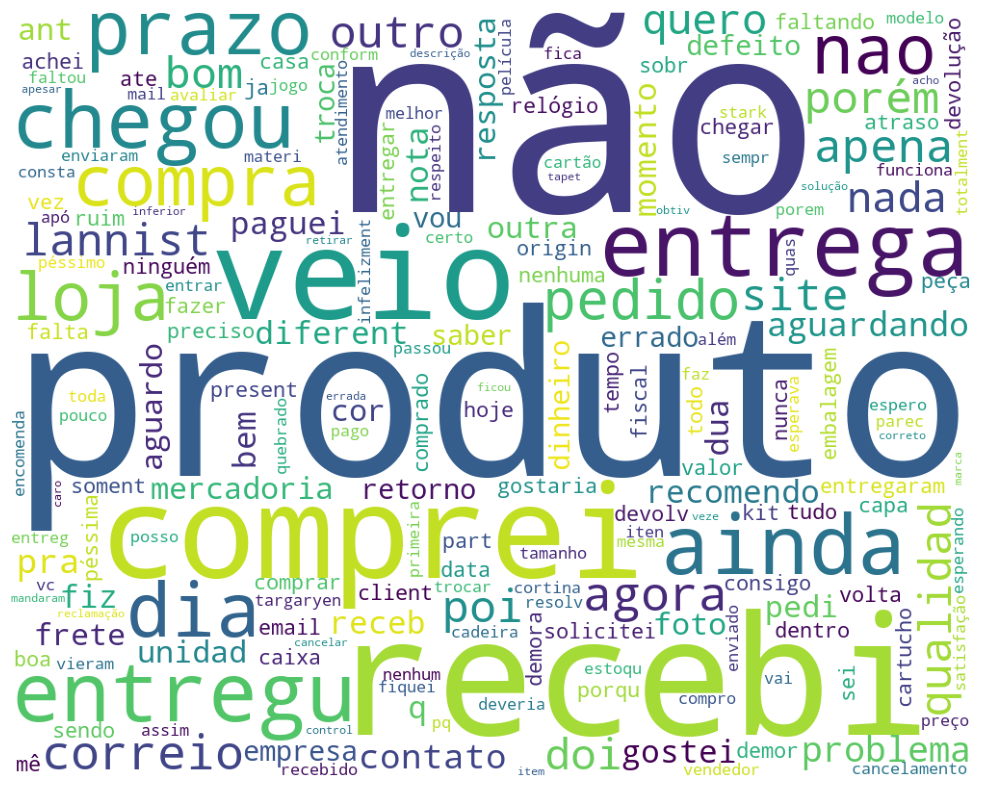

In [219]:
from wordcloud import WordCloud

non_satisfied_final = ' '.join(vocab_list)
non_satisfied_freq = WordCloud(width=1000, height=800, background_color='white').generate(non_satisfied_final)

plt.figure(figsize=(15, 10))
plt.imshow(non_satisfied_freq)
plt.axis("off")

In [220]:
# Sort the word frequencies in descending order
non_satisfied_freq = non_satisfied_freq.process_text(non_satisfied_final)
sorted_word_frequencies = sorted(non_satisfied_freq.items(), key= lambda x : x[1], reverse=True)

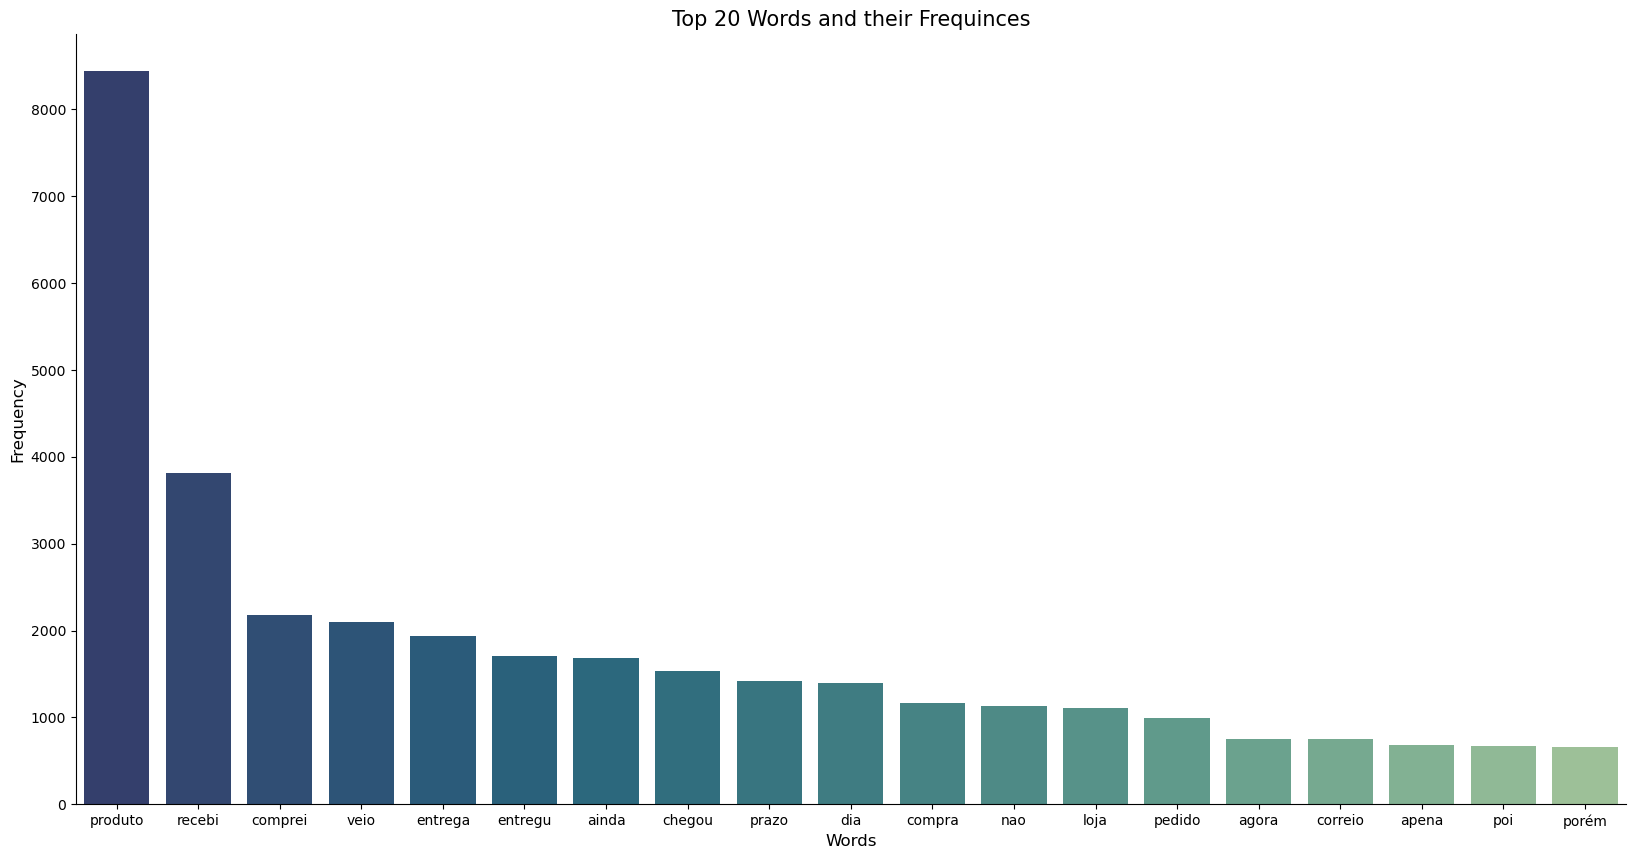

In [221]:
import seaborn as sns
# Plot Words vs Frequency
plt.figure(figsize= [20, 10])
sns.barplot(x = pd.DataFrame(sorted_word_frequencies)[1:20][0], y= pd.DataFrame(sorted_word_frequencies)[1:20][1], palette= 'crest_r')
plt.title('Top 20 Words and their Frequinces', fontsize= 15)
plt.xlabel('Words', fontsize= 12)
plt.ylabel('Frequency', fontsize= 12)
sns.despine()

In [222]:
def get_ngrams_and_res(tokens, N):
    ngrams = [tuple(tokens[i:i+N]) for i in range(len(tokens)-N)]
    res = [tokens[i+N] for i in range(len(tokens)-N)]
    return ngrams, res

# Criar vocabulário
vocab_ngrams = set()
all_ngrams = []
all_res = []
for text in df_aborrecido['review_comment_message']:
    tokens = re.findall(REGEX, text.lower())
    n_grams,res = get_ngrams_and_res(tokens, 3)
    all_ngrams += n_grams
    all_res += res
    vocab_ngrams = vocab_ngrams.union(set(n_grams))

In [223]:
ngrams_dict = dict()
for ngram in all_ngrams:
    if ngram not in ngrams_dict:
        ngrams_dict[ngram] = 0
    ngrams_dict[ngram] += 1

In [224]:
sorted_ngrams_frequencies = sorted(ngrams_dict.items(), key= lambda x : x[1], reverse=True)

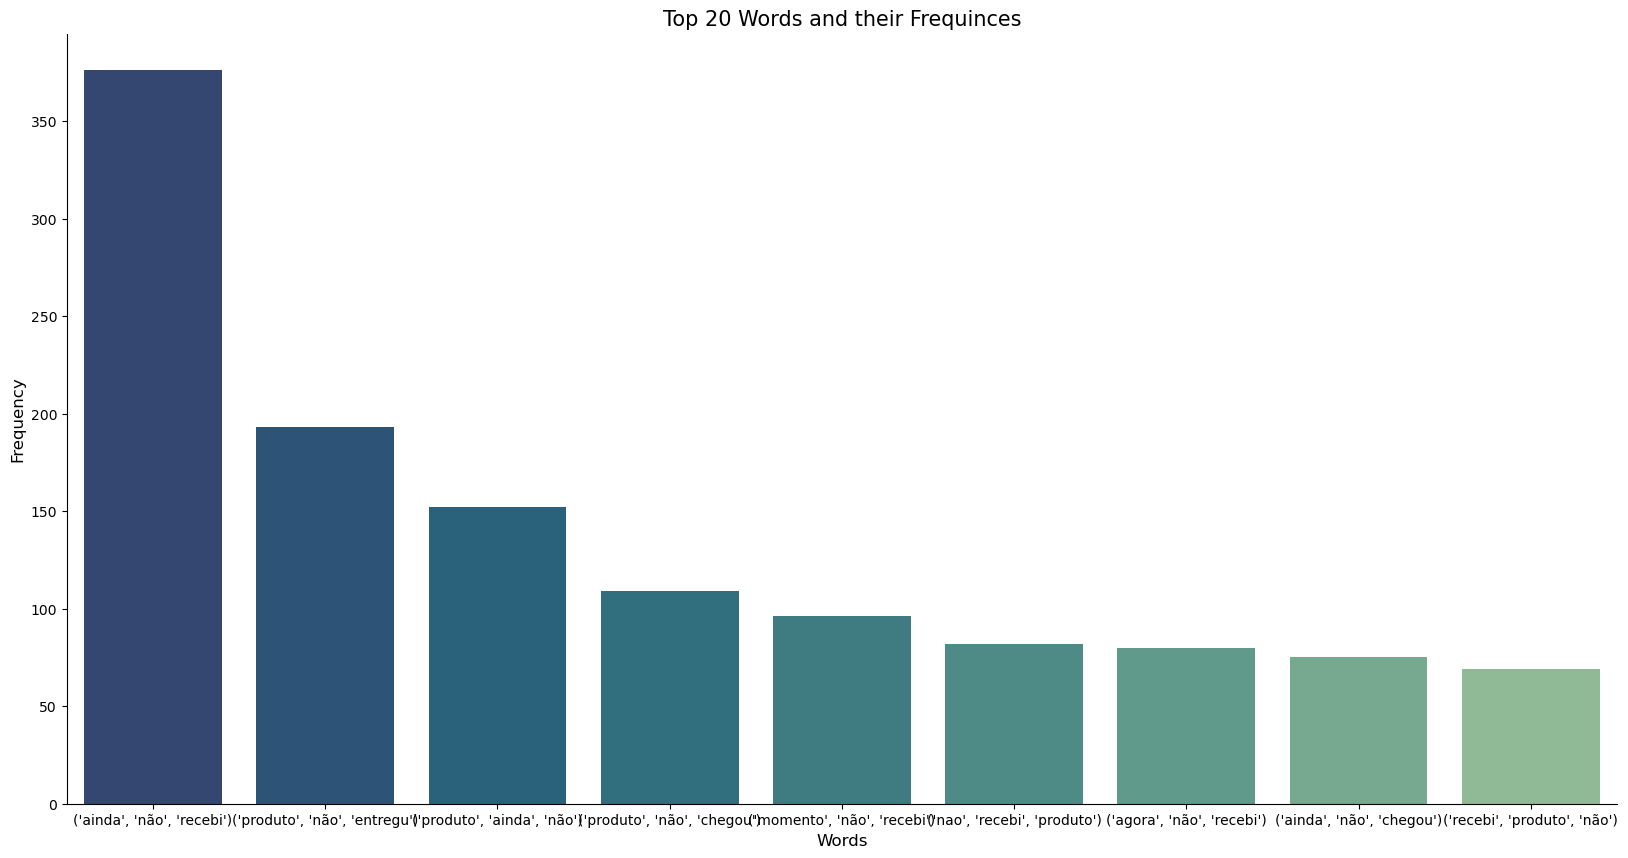

In [225]:
import seaborn as sns
# Plot Words vs Frequency
plt.figure(figsize= [20, 10])
sns.barplot(x = pd.DataFrame(sorted_ngrams_frequencies)[1:10][0], y= pd.DataFrame(sorted_ngrams_frequencies)[1:10][1], palette= 'crest_r')
plt.title('Top 20 Words and their Frequinces', fontsize= 15)
plt.xlabel('Words', fontsize= 12)
plt.ylabel('Frequency', fontsize= 12)
sns.despine()

In [227]:
sorted_ngrams_frequencies[:20]

[(('não', 'recebi', 'produto'), 602),
 (('ainda', 'não', 'recebi'), 376),
 (('produto', 'não', 'entregu'), 193),
 (('produto', 'ainda', 'não'), 152),
 (('produto', 'não', 'chegou'), 109),
 (('momento', 'não', 'recebi'), 96),
 (('nao', 'recebi', 'produto'), 82),
 (('agora', 'não', 'recebi'), 80),
 (('ainda', 'não', 'chegou'), 75),
 (('recebi', 'produto', 'não'), 69),
 (('comprei', 'doi', 'produto'), 61),
 (('recebi', 'apena', '1'), 61),
 (('ainda', 'nao', 'recebi'), 56),
 (('ainda', 'não', 'entregu'), 53),
 (('produto', 'veio', 'defeito'), 52),
 (('produto', 'péssima', 'qualidad'), 43),
 (('produto', 'não', 'veio'), 42),
 (('recebi', 'produto', 'errado'), 40),
 (('chegou', 'ant', 'prazo'), 40),
 (('quero', 'dinheiro', 'volta'), 37)]

Com certeza o maior fator de aborrecimento é o não recebimento do produto. Irei filtrar a palavra recebi para identificar outros fatores com maior facilidade

In [241]:
sorted_word_frequencies_ = [tupla for tupla in sorted_word_frequencies if 'recebi' not in tupla and 'comprei' not in tupla]

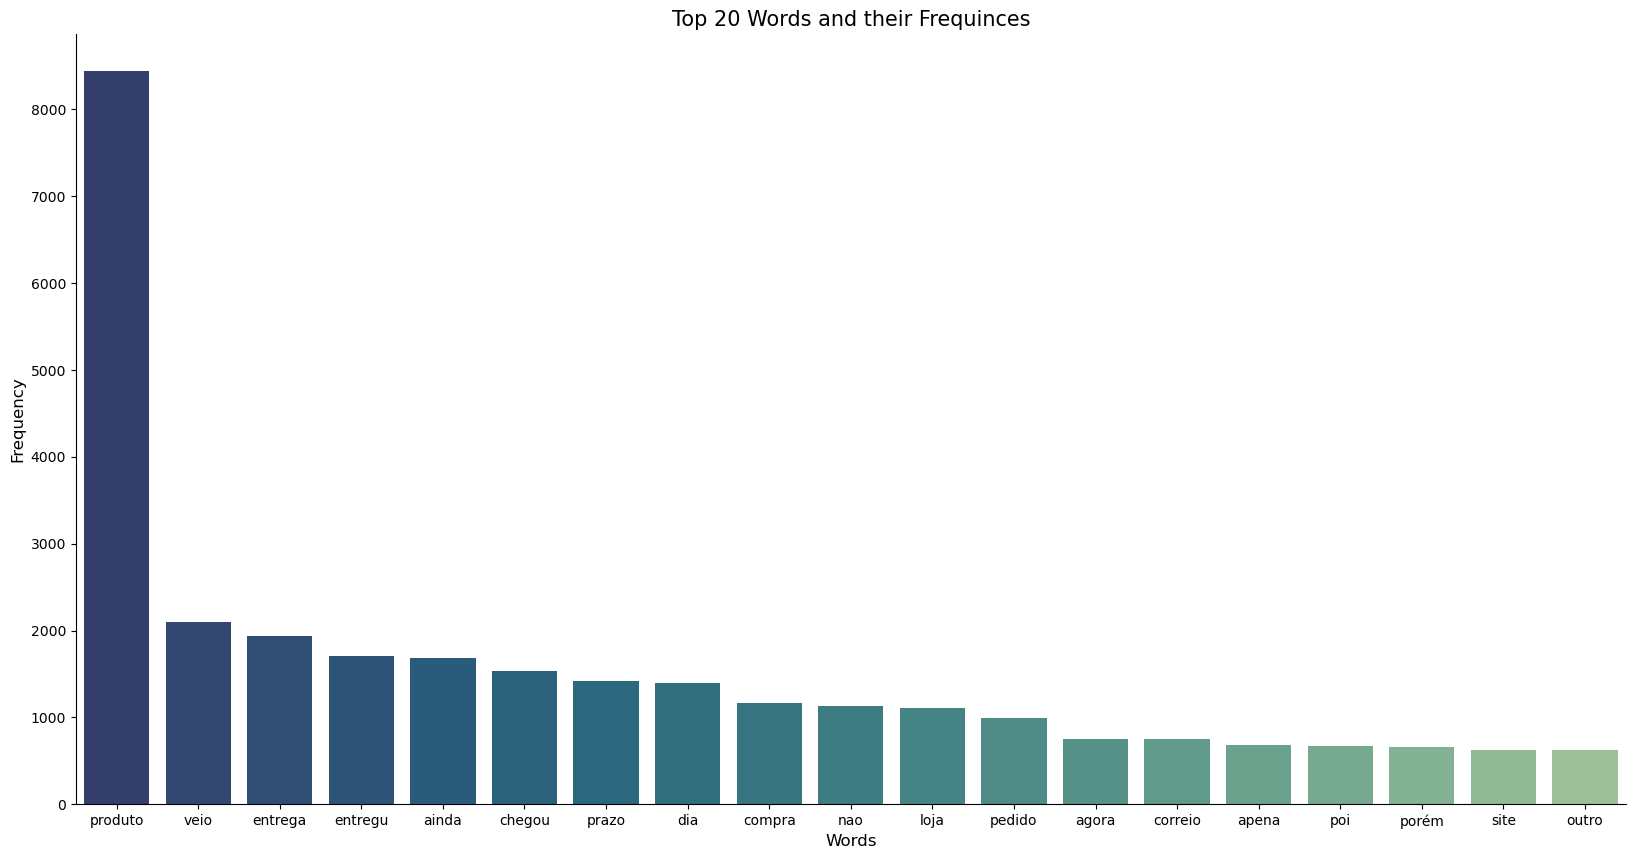

In [242]:
plt.figure(figsize= [20, 10])
sns.barplot(x = pd.DataFrame(sorted_word_frequencies_)[1:20][0], y= pd.DataFrame(sorted_word_frequencies_)[1:20][1], palette= 'crest_r')
plt.title('Top 20 Words and their Frequinces', fontsize= 15)
plt.xlabel('Words', fontsize= 12)
plt.ylabel('Frequency', fontsize= 12)
sns.despine()

In [234]:
sorted_ngrams_frequencies_ = list()
for e in sorted_ngrams_frequencies:
    tupla = e[0]
    freq = e[1]
    if 'recebi' not in tupla:
        sorted_ngrams_frequencies_.append((tupla, freq))

In [243]:
sorted_ngrams_frequencies_

[(('produto', 'não', 'entregu'), 193),
 (('produto', 'ainda', 'não'), 152),
 (('produto', 'não', 'chegou'), 109),
 (('ainda', 'não', 'chegou'), 75),
 (('comprei', 'doi', 'produto'), 61),
 (('ainda', 'não', 'entregu'), 53),
 (('produto', 'veio', 'defeito'), 52),
 (('produto', 'péssima', 'qualidad'), 43),
 (('produto', 'não', 'veio'), 42),
 (('chegou', 'ant', 'prazo'), 40),
 (('quero', 'dinheiro', 'volta'), 37),
 (('não', 'posso', 'avaliar'), 37),
 (('produto', 'veio', 'errado'), 37),
 (('produto', 'entregu', 'não'), 30),
 (('produto', 'chegou', 'ant'), 30),
 (('comprei', '2', 'produto'), 29),
 (('não', 'recomendo', 'loja'), 29),
 (('comprei', 'dua', 'unidad'), 28),
 (('não', 'entregu', 'não'), 28),
 (('poi', 'ainda', 'não'), 28),
 (('não', 'obtiv', 'resposta'), 26),
 (('produto', 'chegou', 'prazo'), 26),
 (('entregu', 'dentro', 'prazo'), 26),
 (('dia', 'ainda', 'não'), 25),
 (('comprei', '2', 'unidad'), 25),
 (('produto', 'veio', 'faltando'), 25),
 (('não', 'chegou', 'não'), 25),
 (('nã